<center>
    
# Beta Bank

**O objetivo deste projeto é prever se um cliente irá deixar o banco em breve.** 

**Iremos analisar os dados sobre o comportamento passado dos clientes e as rescisões de contratos com o banco e, com isso, construiremos um modelo com o valor máximo possível de F1. Nosso alvo é um F1-score de pelo menos 0.59 para o conjunto de dados de teste e, além disso, compararemos a métrica AUC-ROC com o F1-score.**

**Vamos lidar com um objetivo categórico (se o cliente irá deixar o banco ou não), portanto, focaremos nos modelos de classificação.**

## Importação das bibliotecas e módulos necessários

In [151]:
# bibliotecas:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time

# módulos:

    # treinamento de modelos 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

    # separação dos dados
from sklearn.model_selection import train_test_split

    # métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import r2_score

    # pre-processamento
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

## Pré-análise e pré-processamento dos dados

**Nesta etapa iremos carregar os dados e depois analisá-los e alterá-los, se necessário. Iremos focar no padrão dos nomes das colunas, os tipos de dados, dados ausentes e dados repetidos.**

In [152]:
# Carregando os dados do dataframe
df = pd.read_csv('./datasets/Churn.csv')

print(df.head(5))

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [153]:
# Imprimindo as informações gerais do Dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


**Analisando as informações gerais do DataFrame podemos observar que:**

* Ele possui 14 colunas e 10000 linhas;


* Os nomes das colunas precisam ser alterados para snake_case;


* A coluna 'Tenure' possui dados ausentes e precisamos analisá-los;


* Podemos alterar alguns dados para dados de tipo categórico para que fiquem mais condizentes com nossas necessidades: <br/>**Geography, Gender, HasCrCard, IsActiveMember e Exited**

### Renomeação das Colunas

In [154]:
# Criando a variável columns_new com os nomes das colunas em uma lista
columns_new = df.columns

# Transformando a lista em string para poder usar regex
string_columns = '/'.join(columns_new)

# Usando Expressões Regulares (Regex) para alterar as strings inserindo um espaço antes das letras maiúsculas
regex_columns = re.sub('(?=[A-Z])', ' ', string_columns)
regex_columns = regex_columns.split('/')

print(regex_columns)

[' Row Number', ' Customer Id', ' Surname', ' Credit Score', ' Geography', ' Gender', ' Age', ' Tenure', ' Balance', ' Num Of Products', ' Has Cr Card', ' Is Active Member', ' Estimated Salary', ' Exited']


In [155]:
# Criando a lista vazia para anexar os nomes das colunas após transformações
new_col_names = []

# Criando loop para renomear todas as colunas em snake_case
for name in regex_columns:
    name_stripped = name.strip()
    name_lowered = name_stripped.lower()
    name_no_spaces = name_lowered.replace(' ', '_')
    
    new_col_names.append(name_no_spaces)

print(new_col_names)

['row_number', 'customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']


In [156]:
# Renomeando as colunas do DataFrame com os nomes modificados anteriormente
df.columns = new_col_names

print(df.columns)

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')


### Alteração de tipos de dados

#### Alteração de dados para dados de tipo categórico:

In [157]:
# Criando a lista com as colunas que precisam ser alteradas para 'category'
category_list = ['geography', 'gender', 'has_cr_card', 'is_active_member','exited']

# Criando loop para alterar as colunas da lista para dados do tipo 'category' com método astype
for element in category_list:
    df[element] = df[element].astype('category')

### Análise da coluna 'tenure'

**Vamos filtrar o dataframe somente com as linhas em que a coluna 'tenure' tem dados ausentes e verificar se encontramos algum padrão**

In [158]:
print(df[df['tenure'].isna()].sample(5))

      row_number  customer_id    surname  credit_score geography  gender  age  \
3778        3779     15658486     Gidney           579     Spain  Female   59   
2239        2240     15648577  Pickering           493    France  Female   31   
4216        4217     15718852       Uren           794    France    Male   56   
3592        3593     15628886    Matlock           677     Spain    Male   56   
6794        6795     15694098    Jackson           575    France  Female   54   

      tenure    balance  num_of_products has_cr_card is_active_member  \
3778     NaN  148021.12                1           1                1   
2239     NaN       0.00                1           1                1   
4216     NaN   96951.21                1           1                1   
3592     NaN  123959.97                1           1                1   
6794     NaN   68332.96                1           1                1   

      estimated_salary exited  
3778          74878.22      0  
2239      

Não foi observado nenhum padrão  nas outras colunas quando temos dados ausentes na coluna 'tenure'. 

Vamos avaliar se quando 'tenure' é NaN temos uma tendência maior de obter "1" na coluna 'exited', ou seja, se quando 'tenure' é NaN temos uma maior tendência do cliente deixar o banco.

In [159]:
# Filtrando um DataFrame quando a coluna 'tenure' tem dados ausentes
df_tenure_isna = df[df['tenure'].isna()]

# Contando quantos valores "0" e "1" temos na coluna 'exited' quando a coluna 'tenure' tem dados ausentes
print(df_tenure_isna['exited'].value_counts())

exited
0    726
1    183
Name: count, dtype: int64


In [160]:
# Contando quantos valores "0" e "1" temos na coluna 'exited' no DataFrame completo
print(df['exited'].value_counts())

exited
0    7963
1    2037
Name: count, dtype: int64


In [161]:
# Calculando as taxas da classe "1" em cada um dos casos acima
print('taxa_tenure_isna_exited', (183/726))
print()
print('taxa_tenure_exited', (2037/7963))

taxa_tenure_isna_exited 0.25206611570247933

taxa_tenure_exited 0.25580811252040686


A taxa de clientes que deixam o banco quando 'tenure' é NaN e quando não é, é praticamente a mesma. Portanto, isso não influencia no resultado e então vamos assumir que estes dados são de fato inexistentes devido a não contratação deste tipo de serviço pelos clientes.

Como não podemos ter dados NaN quando formos treinar nossos modelos, vamos preenchê-los com (-1).

In [162]:
# Preenchendo dados ausentes na coluna 'tenure' com -1
df['tenure'] = df['tenure'].fillna(-1)

#### Checagem de linhas duplicadas: ###

In [163]:
# Imprimindo número de linhas totalmente duplicadas
print(df.duplicated().sum())

0


### Checagem do DataFrame após pré-processamento

In [164]:
# Imprimindo uma amostra de 5 linhas do DataFrame após pré-processamento
print(df.sample(5))

      row_number  customer_id     surname  credit_score geography  gender  \
2303        2304     15635078    Chiemela           714     Spain    Male   
3648        3649     15691703        Shih           545    France    Male   
695          696     15748625  Napolitano           664    France    Male   
9085        9086     15579189    Mitchell           690    France  Female   
8333        8334     15743709      Toomey           683    France    Male   

      age  tenure    balance  num_of_products has_cr_card is_active_member  \
2303   45     0.0  124693.48                1           0                1   
3648   47     8.0  105792.49                1           0                1   
695    57     6.0       0.00                2           1                1   
9085   42     5.0       0.00                2           0                1   
8333   30     4.0   66190.33                1           1                1   

      estimated_salary exited  
2303         187194.15      0  
3648

## Preparação dos dados

Nesta etapa, vamos preparar os dados da melhor forma para que façamos os treinamentos de nossos modelos.

Vamos remover informações desnecessárias e transformar os dados, de forma que dados categóricos possam ser codificados como dados numéricos e os dados numéricos tenham suas escalas padronizadas para que os nossos modelos não os interpretem de forma equivocada.

### Remoção de colunas desnecessárias

Algumas colunas não serão necessárias e podem até mesmo prejudicar o modelo por conterem dados numéricos, como 'row_number' e  'customer_id'. A coluna 'surname' também será removida.

In [165]:
df_clean = df.drop(['row_number', 'customer_id', 'surname' ], axis = 1)
print(df_clean.sample(5))

      credit_score geography  gender  age  tenure    balance  num_of_products  \
4928           513     Spain    Male   39     7.0   89039.90                2   
4862           645     Spain  Female   55     1.0  133676.65                1   
8041           698     Spain  Female   50     1.0       0.00                4   
450            494   Germany  Female   38     7.0  174937.64                1   
2537           573    France  Female   33    -1.0   90124.64                1   

     has_cr_card is_active_member  estimated_salary exited  
4928           1                1         146738.83      0  
4862           0                1          17095.49      0  
8041           1                0          88566.90      1  
450            1                0          40084.32      0  
2537           1                0         137476.71      0  


### Divisão dos dados em treinamento, validação e teste

In [166]:
# Definindo as colunas que serão tratadas como características e objetivo
features = df_clean.drop('exited', axis=1)
target = df_clean['exited']

# Na primeira etapa, dividiremos os dados em "treinamento" e "conjunto de dados restantes" 
features_train, features_rem, target_train, target_rem = train_test_split(features, target, train_size=0.6, random_state = 12345)

# Agora, queremos que os tamanhos dos conjuntos de validação e teste sejam iguais 
# Portanto, vamos definir test_size que represente 50% dos dados restantes (dividir os dados restantes no meio)
features_valid, features_test, target_valid, target_test = train_test_split(features_rem, target_rem, test_size=0.5, random_state = 12345)

print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(6000, 10)
(6000,)
(2000, 10)
(2000,)
(2000, 10)
(2000,)


### Codificação dos dados

In [202]:
# Criando listas separando os dados numéricos e categóricos que precisam ser ajustados
numeric = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
categorical = ['geography', 'gender']

# Fazendo cópias explícitas dos DataFrames para evitar warnings
features_train = features_train.copy()
features_valid = features_valid.copy()
features_test = features_test.copy()


# Codificação das colunas categóricas usando OrdinalEncoder apenas no conjunto de treino
encoder = OrdinalEncoder()
features_train.loc[:, categorical] = encoder.fit_transform(features_train[categorical])
features_valid.loc[:, categorical] = encoder.transform(features_valid[categorical])
features_test.loc[:, categorical] = encoder.transform(features_test[categorical])


# Padronização das colunas numéricas usando StandardScaler
scaler = StandardScaler()
features_train.loc[:, numeric] = scaler.fit_transform(features_train[numeric])
features_valid.loc[:, numeric] = scaler.transform(features_valid[numeric])
features_test.loc[:, numeric] = scaler.transform(features_test[numeric])


# Imprimir os resultados para verificação
print(features_train.head(2))
print(features_train.shape)
print()
print()
print(features_valid.head(2))
print(features_valid.shape)
print()
print()
print(features_test.head(2))
print(features_test.shape)

      credit_score  geography  gender       age    tenure   balance  \
7479     -0.886751        2.0     1.0 -0.373192  1.083651  1.232271   
3411      0.608663        0.0     0.0 -0.183385  1.083651  0.600563   

      num_of_products has_cr_card is_active_member  estimated_salary  
7479                1           1                0         -0.187705  
3411                1           0                0         -0.333945  
(6000, 10)


      credit_score  geography  gender       age    tenure   balance  \
8532     -0.699824        0.0     0.0 -0.373192 -0.760164 -1.233163   
5799     -0.284431        0.0     0.0  0.575842 -0.452862 -1.233163   

      num_of_products has_cr_card is_active_member  estimated_salary  
8532                2           1                0         -0.015173  
5799                1           1                1          1.471724  
(2000, 10)


      credit_score  geography  gender       age    tenure   balance  \
7041     -2.226392        0.0     1.0 -0.088482 -

## Treinamento dos primeiros modelos

**Nesta etapa iremos treinar um primeiro modelo para cada uma das tarefas de classificação, sem levar em conta o desequilíbrio das classes, com o objetivo de observar os resultados e compará-los com os resultados obtidos após realizar as etapas de ajustes das classes:**

### Primeira Regressão Logística

In [168]:
# Treinando o primeiro modelo de Regressão Logística e calculando sua acurácia
first_model_regression = LogisticRegression() 
first_model_regression.fit(features_train, target_train)
first_score_valid_regression = first_model_regression.score(features_valid, target_valid)

print('Acurácia primeiro modelo de Regressão Logística:', first_score_valid_regression)

Acurácia primeiro modelo de Regressão Logística: 0.8035


**Se analisarmos somente a acurácia, o resultado parece satisfatório. Porém, precisamos tirar a prova real.**

#### Prova Real

##### Para fazer a prova real, vamos começar verificando a frequência com que a característica 'Target' contém a classe "1" ou "0"

In [169]:
class_frequency = df_clean['exited'].value_counts(normalize=True)
print(class_frequency)

exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


Temos a classe "0" com 80% dos dados, ou seja, muito mais resultados do que a classe "1". Portanto temos um desequilíbrio de classes em nosso problema. 
**A razão das classes dos dados é de 4:1**

##### Agora vamos analisar as frequências de classe das predições do nosso primeiro modelo de Regressão

In [170]:
# Analisando as frequências de classe das predições do primeiro modelo de regressão
first_reg_predict_valid = pd.Series(first_model_regression.predict(features_valid))
class_frequency_first_reg = first_reg_predict_valid.value_counts(normalize=True)

print(class_frequency_first_reg)

0    0.9365
1    0.0635
Name: proportion, dtype: float64


Nosso modelo previu 94% das observações como sendo da classe "0" (negativas). Uma quantidade muito maior do que os dados reais do Target, que já eram desequilibrados. Isso nos indica que nosso modelo provavelmente tem uma sensibilidade baixa e precisa de ajustes.

##### Vamos comparar  o modelo de Regressão Logística com um modelo constante que prevê a classe "0" para todas as observações

In [171]:
# Criando um modelo que prevê a classe "0" para todas as observações
target_pred_constant = pd.Series(0, range(10000))

# Calculando a acurácia do modelo constante
print('Acurácia do modelo constante:', accuracy_score(target, target_pred_constant))

Acurácia do modelo constante: 0.7963


A acurácia do modelo constante foi de aproximadamente 80%, assim como a do nosso modelo de Regressão logística. isso nos mostra que nosso modelo não é melhor do que um modelo constante que prevê a mesma resposta para todas as observações, ou seja, mais uma evidência de que nosso modelo precisa de ajustes.

Como sabemos, a acurácia não avalia bem um modelo em cenário de desequilíbrio de classes. Nestes cenários precisamos olhar para outras métricas, como "Sensibilidade" e "Precisão". Então vamos começar imprimindo nossa **MATRIZ DE CONFUSÃO**, que nos mostra nossos resultados em **VN, VP, FN E FP**, ou seja, "Verdadeiros Negativos", "Verdadeiros Positivos", "Falsos Negativos" e "Falsos Positivos"

##### Matriz de confusão do modelo de Regressão Logística

In [172]:
# Imprimindo a matriz de confusão para verificar o número de VP,VN,FP e FN.
print('  VN      FP')
print(confusion_matrix(target_valid, first_reg_predict_valid))
print('  FN      VP')

  VN      FP
[[1531   51]
 [ 342   76]]
  FN      VP


In [173]:
print('A precisão do modelo é:', precision_score(target_valid, first_reg_predict_valid))
print('A sensibilidade do modelo é:', recall_score(target_valid, first_reg_predict_valid))

A precisão do modelo é: 0.5984251968503937
A sensibilidade do modelo é: 0.18181818181818182


Como a sensibilidade do nosso modelo é muito baixa, ele prevê poucas respostas positivas. Isso faz com que tenhamos poucos Falsos Positivos, mas em compensação temos muitos Falsos Negativos.

Porém, analisar Sensibilidade e Precisão de forma separada, não nos diz muita coisa. Elas precisam andar juntas e, para facilitar, temos a **métrica de agregação, F1_score**. Ela é a média harmônica das métricas de sensibilidade e precisão e nos dá um panorama melhor da qualidade do modelo em situações de desequilíbrio de classes. Vamos calculá-la:

##### Cálculo do F1 do primeiro modelo de Regressão Logística

In [174]:
# Calculando F1_score para nosso primeiro modelo de regressão
first_predicted_valid_reg = first_model_regression.predict(features_valid)
print('F1 do primeiro modelo de Regressão:', f1_score(target_valid, first_predicted_valid_reg))

F1 do primeiro modelo de Regressão: 0.27889908256880735


#### Conclusões primeiro modelo de Regressão Logística

Com essas análises de Prova Real, podemos observar que nosso primeiro modelo não é bom. Ele previu a classe "0" para 94% das observações e ainda assim, não obteve melhor resultado do que um modelo que prevê a classe "0" para todas as observações, sendo que os 2 modelos acertariam cerca de 80% das observações.

Se analisássemos somente a acurácia, nosso modelo daria uma falsa impressão de ser bom. Porém, o nosso resultado de F1 = 0.28 nos indica que o modelo é ruim.

Esses resultados são consequência do nosso desequilíbrio de classes.

### Primeira Árvore Decisória

In [175]:
# Treinando um modelo de árvore decisória e calculando sua acurácia
first_model_tree = DecisionTreeClassifier() 
first_model_tree.fit(features_train, target_train)
first_score_valid_tree = first_model_tree.score(features_valid, target_valid)

print('Acurácia do primeiro modelo de Árvore Decisória:', first_score_valid_tree)

Acurácia do primeiro modelo de Árvore Decisória: 0.78


#### Prova Real

##### Para fazer a prova real, vamos começar verificando a frequência com que a característica 'Target' contém a classe "1" ou "0"

In [176]:
print(class_frequency)

exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


Temos a classe "0" com 80% dos dados, ou seja, muito mais resultados do que a classe "1". Portanto temos um desequilíbrio de classes em nosso problema. 
**A razão das classes dos dados é de 4:1**

##### Agora vamos analisar as frequências de classe das predições do nosso primeiro modelo de Árvore Decisória

In [177]:
# Analisando as frequências de classe das predições do modelo
first_predict_valid_tree = pd.Series(first_model_tree.predict(features_valid))
class_frequency_tree = first_predict_valid_tree.value_counts(normalize=True)

print(class_frequency_tree)

0    0.791
1    0.209
Name: proportion, dtype: float64


##### Vamos comparar  o modelo de Árvore Decisória com um modelo constante que prevê a classe "0" para todas as observações

In [178]:
# Criando um modelo que prevê a classe "0" para todas as observações
target_pred_constant = pd.Series(0, range(10000))

# Calculando a acurácia do modelo constante
print('Acurácia do modelo constante:', accuracy_score(target, target_pred_constant))

Acurácia do modelo constante: 0.7963


##### Matriz de confusão do modelo de Árvore Decisória

In [179]:
# Imprimindo a matriz de confusão para verificar o número de VP,VN,FP e FN.
print('  VN      FP')
print(confusion_matrix(target_valid, first_predict_valid_tree))
print('  FN      VP')

  VN      FP
[[1362  220]
 [ 220  198]]
  FN      VP


In [180]:
print('A precisão do modelo é:', precision_score(target_valid, first_predict_valid_tree))
print('A sensibilidade do modelo é:', recall_score(target_valid, first_predict_valid_tree))

A precisão do modelo é: 0.47368421052631576
A sensibilidade do modelo é: 0.47368421052631576


Este modelo é um pouco mais equilibrado do que o modelo de Regressão logística. Apresenta uma sensibilidade maior, o que implica que tenhamos mais predições positivas e, consequentemente, mais Falsos Positivos e menos Falsos Negativos que o modelo anterior. Mas, conforme explicado anteriormente, precisamos calcular e analisar o F1-Score ao invés de analisarmos separadamente a sensibilidade e a precisão.

##### Cálculo do F1 do primeiro modelo de Árvore Decisória

In [181]:
first_predicted_valid_tree = first_model_tree.predict(features_valid)
print('F1 do primeiro modelo de Árvore Decisória:', f1_score(target_valid, first_predicted_valid_tree))

F1 do primeiro modelo de Árvore Decisória: 0.47368421052631576


#### Conclusões primeiro modelo de árvore

A acurácia do modelo foi de 77%, enquanto que a de um modelo constante que prevê a classe "0" para todas as respostas, teria uma acurácia de 80%, ou seja, a acurácia do nosso modelo foi ainda menor do que a do modelo constante.

Nosso modelo previu a classe "0" para 80% das observações, uma quantia bem próxima à quantia real das respostas da nossa coluna Target, porém, se analisarmos a Matriz de Confusão, podemos observar que nosso modelo previu mais Falsos Positivos do que Verdadeiros Positivos. isso nos indica que nosso modelo não está realmente aprendendo padrões importantes no conjunto de dados.

Além dessas observações, o nosso resultado de F1 = 0.46 nos indica que o modelo não é bom e precisa ser melhorado.

### Primeira Floresta Aleatória

In [182]:
# Treinando um modelo de Floresta Aleatória e calculando sua acurácia
first_model_forest = RandomForestClassifier() 
first_model_forest.fit(features_train, target_train)
first_score_valid_forest = first_model_forest.score(features_valid, target_valid)

print('Acurácia do primeiro modelo de Floresta Aleatória:', first_score_valid_forest)

Acurácia do primeiro modelo de Floresta Aleatória: 0.855


**Se analisarmos somente a acurácia, o resultado parece bem satisfatório. Porém, precisamos analisar a prova real.**

####  Prova Real

##### Para fazer a prova real, vamos começar verificando a frequência com que a característica 'Target' contém a classe "1" ou "0"

In [183]:
print(class_frequency)

exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


Temos a classe "0" com 80% dos dados, ou seja, muito mais resultados do que a classe "1". Portanto temos um desequilíbrio de classes em nosso problema. 
**A razão das classes dos dados é de 4:1**

##### Agora vamos analisar as frequências de classe das predições do nosso primeiro modelo de Floresta Aleatória

In [184]:
# Analisando as frequências de classe das predições do modelo
first_predict_valid_forest = pd.Series(first_model_forest.predict(features_valid))
class_frequency_forest = first_predict_valid_forest.value_counts(normalize=True)

print(class_frequency_forest)

0    0.875
1    0.125
Name: proportion, dtype: float64


Nosso modelo previu 88% das respostas na classe "0", enquanto no Target real, essa classe tem 80% dos resultados

##### Vamos comparar  o modelo de Floresta Decisória com um modelo constante que prevê a classe "0" para todas as observações

In [185]:
# Criando um modelo que prevê a classe "0" para todas as observações
target_pred_constant = pd.Series(0, range(10000))

# Calculando a acurácia do modelo constante
print('Acurácia do modelo constante:', accuracy_score(target, target_pred_constant))

Acurácia do modelo constante: 0.7963


A acurácia do modelo constante foi de aproximadamente 80% e a do nosso modelo de Floresta Aleatória foi de 85%. isso nos mostra que nosso modelo é um pouco melhor do que um modelo constante que prevê a mesma resposta para todas as observações, mas precisamos analisar mais alguns parâmetros.

##### Matriz de confusão do modelo de Floresta Aleatória

In [186]:
# Imprimindo a matriz de confusão para verificar o número de VP,VN,FP e FN.
print('  VN      FP')
print(confusion_matrix(target_valid, first_predict_valid_forest))
print('  FN      VP')

  VN      FP
[[1521   61]
 [ 229  189]]
  FN      VP


In [187]:
print('A precisão do modelo é:', precision_score(target_valid, first_predict_valid_forest))
print('A sensibilidade do modelo é:', recall_score(target_valid, first_predict_valid_forest))

A precisão do modelo é: 0.756
A sensibilidade do modelo é: 0.45215311004784686


Este modelo a princípio foi o que obteve melhores parâmetros de sensibilidade e precisão, o que nos diz que, provavelmente, é o melhor modelo até aqui. Ele apresentou uma precisão satisfatória, mas ainda está um pouco desequilibrado em relação à sensibilidade. O modelo previu 88% das respostas sendo negativas, enquanto os dados reais nos dizem que 80% são negativas, portanto, o modelo ainda precisa de ajustes. Vamos analisar o F1_score para compará-lo com os demais modelos.

##### Cálculo do F1 do primeiro modelo de Floresta Decisória

In [188]:
first_predicted_valid_forest = first_model_forest.predict(features_valid)
print('F1 do primeiro modelo de Floresta Aleatória:', f1_score(target_valid, first_predicted_valid_forest))

F1 do primeiro modelo de Floresta Aleatória: 0.5658682634730539


#### Conclusões primeiro modelo de floresta aleatória

Se analisássemos somente a acurácia, nosso modelo daria uma falsa impressão de ser muito bom. Porém, tirando a Prova Real, é possível observar que, apesar de ser melhor do que os outros modelos, ele ainda precisa ser ajustado. 

A acurácia do modelo foi de 86%, enquanto que a de um modelo constante que prevê a classe "0" para todas as respostas, teria uma acurácia de 80%, ou seja, a acurácia do nosso modelo foi um pouco superior à acurácia do modelo constante.

Analisando a Matriz de Confusão, podemos observar que nosso modelo previu ainda muitos Falsos Negativos, nos demonstrando que está com uma sensibilidade um pouco baixa.

Nosso resultado de F1 = 0.56 já nos trouxe um resultado bem melhor do que nos outros modelos treinados, mas ainda não é o suficiente e nos indica que o modelo precisa ser ajustado.

### Conclusões gerais após primeiros modelos

Quando analisamos dados com classes desequilibradas precisamos antes resolver este problema de desequilíbrio e também levar em conta que a acurácia não é a melhor métrica para avaliarmos os resultados do modelo nesses casos. A acurácia poderia nos dar a falsa impressão de termos um bom modelo, mas na verdade pode ser que o modelo não seja melhor nem mesmo que um modelo constante que prevê somente um tipo de respostas.

Portanto, ao testarmos e descobrirmos que os dados tem classes desequilibradas, precisamos analisar outras métricas, como a Sensibilidade e Precisão, ou o F1_score, que é a média harmônica entre essas duas métricas.

Podemos também traçar a Matriz de Confusão que nos mostra mais detalhadamente a quantidade de previsões que nosso modelo acertou ou errou e nos dá um panorama para sabermos o desempenho da Sensibilidade e da Precisão do modelo.

Por fim, é necessário que façamos um tratamento deste desequilíbrio de classes com algumas técnicas, para depois treinarmos nossos modelos e assim, obtermos melhores resultados.

## Tratamento do desequilíbrio de classes

Para tratar o Desequilíbrio das Classes, vamos utilizar as técnicas de **Superamostragem**, **Ajuste de Limiar** e também o **Ajuste de Ponderação de Classe**.

Para a Superamostragem, inicialmente criaremos uma função que realiza a Superamostragem, para que possamos chamá-la ao realizarmos os treinamentos dos modelos. Vamos considerar a razão das classes de 4:1, conforme foi encontrada anteriormente.

Para o Ajuste de Limiar, calcularemos o melhor limiar dentro de cada código para encontrarmos o melhor modelo possível. 

Para o Ajuste de Ponderação de Classe, basta configurar o argumento class_weight de cada modelo para 'balanced'. 

In [189]:
# Definindo a função upsample para realizar uma superamostragem da classe rara para tratar o desequilíbrio das classes

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = 12345)
    
    return features_upsampled, target_upsampled

## Treinamento dos modelos

Nesta etapa iremos realizar o treinamento dos 3 tipos de modelos de classificação (Regressão Logística, Árvore Decisória e Floresta Aleatória) após eliminarmos o desequilíbrio das classes. 

Depois, iremos calcular o F1_Score obtido para cada modelo, e assim definiremos com qual modelo seguir.

### Regressão Logística

In [190]:
# Chamando a função upsample para criar uma superamsotragem da classe rara
# Devido a razão das classes ser de 4:1, iremos multiplicar os dados da classe rara por 4
reg_features_upsampled, reg_target_upsampled = upsample(features_train, target_train, 4)


# Iniciando o registro de tempo de execução do código
inicio_regression = time.time()

# criando as variáveis para comparação do melhor modelo no ciclo for
best_f1_reg = 0
best_threshold = 0

# Treinando o modelo de Regressão Logística com class_weight = 'balanced'
model_regression = LogisticRegression(random_state = 12345, solver = 'liblinear', class_weight = 'balanced')
model_regression.fit(reg_features_upsampled, reg_target_upsampled)


# Realizando o ajuste de limiar para testar o melhor modelo 
reg_probabilities_valid = model_regression.predict_proba(features_valid)
reg_probabilities_one_valid = reg_probabilities_valid[:, 1]

for threshold in np.arange(0, 0.6, 0.02): # Testando limiares de 0 a 0.4 com incrementos de 0.02
    reg_predicted_valid = reg_probabilities_one_valid > threshold
    f1_reg = f1_score(target_valid, reg_predicted_valid)
    
    if f1_reg > best_f1_reg:
        best_f1_reg = f1_reg
        best_threshold = threshold


# finalizando o registro de tempo de execução do código
fim_regression = time.time()


print("f1 do melhor modelo de Regressão Logística (threshold = {}) é: {}".format(best_threshold, best_f1_reg))

# imprimindo o tempo de execução em segundos
print()
print('Tempo de execução:', fim_regression - inicio_regression, 'segundos')

f1 do melhor modelo de Regressão Logística (threshold = 0.58) é: 0.4914400805639476

Tempo de execução: 0.30260729789733887 segundos


### Árvore de Decisão

In [191]:
# Chamando a função upsample para criar uma superamsotragem da classe rara
# Devido a razão das classes ser de 4:1, iremos multiplicar os dados da classe rara por 4
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

# iniciando o registro de tempo de execução do código
inicio_tree = time.time()


# criando as variáveis para comparação do melhor modelo no ciclo for
best_f1_tree = 0
best_depth = 0
best_criterion = None
best_min_samples_leaf = 0
best_tree_threshold = 0

for criterion in ['gini', 'entropy']: # testando melhor criterio para o modelo
    for leaf in range(1, 11): # testando melhor número de amostras por folha para o modelo
        for depth in range(1, 11): # testando melhor profundidade máxima para o modelo
            model_tree = DecisionTreeClassifier(min_samples_leaf = leaf, max_depth = depth, criterion = criterion, 
                random_state = 12345, class_weight = 'balanced') # incluindo random_state e class_weight = 'balanced'
            model_tree.fit(features_upsampled, target_upsampled) # treinando o modelo com os dados de treinamento superamostrados
            
            
            # Realizando o ajuste de limiar para testar o melhor modelo 
            tree_probabilities_valid = model_tree.predict_proba(features_valid)
            tree_probabilities_one_valid = tree_probabilities_valid[:, 1]

            for threshold in np.arange(0, 0.6, 0.02): # Testando limiares de 0 a 0.4 com incrementos de 0.02
                tree_predicted_valid = tree_probabilities_one_valid > threshold
                f1_tree = f1_score(target_valid, tree_predicted_valid) # Calculando F1 do modelo
    
                # comparando os modelos para definir os melhores hiperparâmetros
                if f1_tree > best_f1_tree:
                    best_f1_tree = f1_tree
                    best_tree_threshold = threshold
                    best_depth = depth
                    best_criterion = criterion
                    best_min_samples_leaf = leaf
            
    
print("f1 do melhor modelo de árvore decisória (threshold = {}, max_depth = {}, criterion = {} e min_samples_leaf = {}) é: {}"
      .format(best_tree_threshold, best_depth, best_criterion, best_min_samples_leaf, best_f1_tree))
print()


# finalizando o registro de tempo de execução do código
fim_tree = time.time()

# imprimindo o tempo de execução em segundos
print('Tempo de execução:', fim_tree - inicio_tree, 'segundos')

f1 do melhor modelo de árvore decisória (threshold = 0.58, max_depth = 5, criterion = entropy e min_samples_leaf = 9) é: 0.6130884041331802

Tempo de execução: 38.16415524482727 segundos


### Floresta Aleatória

In [192]:
# iniciando o registro de tempo de execução do código
inicio_forest = time.time()


# criando as variáveis para comparação do melhor modelo no ciclo for
best_f1_forest = 0
best_est = 0
best_bootstrap = None
best_forest_depth = 0
best_forest_threshold = 0

for bootstrap in [True, False]: # verificando qual melhor bootstrap para o modelo
    for forest_depth in range(1, 11): # testando melhor hiperparâmetro de profundidade máxima para o modelo
        for est in range(1, 11): # testando modelos com hiperparâmetro de quantidade de árvores de 1 a 10
            model_forest = RandomForestClassifier(bootstrap = bootstrap, max_depth = depth, n_estimators = est, 
                        random_state = 12345, class_weight = 'balanced') # incluindo random_state e class_weight = 'balanced'
            model_forest.fit(features_upsampled, target_upsampled) # treinando modelo com dados superamostrados na classe rara
            
            # Realizando o ajuste de limiar para testar o melhor modelo 
            forest_probabilities_valid = model_forest.predict_proba(features_valid)
            forest_probabilities_one_valid = forest_probabilities_valid[:, 1]

            for threshold in np.arange(0, 0.6, 0.02): # Testando limiares de 0 a 0.4 com incrementos de 0.02
                forest_predicted_valid = forest_probabilities_one_valid > threshold
                f1_forest = f1_score(target_valid, forest_predicted_valid)
    
                # comparando os modelos para definir os melhores hiperparâmetros
                if f1_forest > best_f1_forest:
                    best_f1_forest = f1_forest
                    best_forest_threshold = threshold
                    best_est = est
                    best_bootstrap = bootstrap
                    best_forest_depth = forest_depth
        
print("F1 do melhor modelo de floresta aleatória (threshold = {}, max_depth = {}, bootstrap = {} e n_estimator = {}) é: {}"
      .format(best_forest_threshold, best_forest_depth, best_bootstrap, best_est, best_f1_forest))
print()


# finalizando o registro de tempo de execução do código
fim_forest = time.time()

# imprimindo o tempo de execução em segundos
print('Tempo de execução:', fim_forest - inicio_forest, 'segundos')

F1 do melhor modelo de floresta aleatória (threshold = 0.54, max_depth = 1, bootstrap = True e n_estimator = 10) é: 0.6006674082313682

Tempo de execução: 44.479142904281616 segundos


### Conclusões

Resolvemos os nossos problemas de desequilíbrios de classes e encontramos nosso melhor modelo para cada tipo, sendo:

* **Regressão Logística:** F1_Score = 0.4914 com (random_state = 12345, solver = 'liblinear' e threshold = 0.58). Com um tempo de execução de apenas 0.24 segundos;


* **Árvore Decisória:** F1_Score = 0.6131 com (threshold = 0.58, max_depth = 5, criterion = entropy, min_samples_leaf = 9 e random_state = 12345). Com um tempo de execução de 20.74 segundos;


* **Floresta Aleatória:** F1_Score = 0.5975 com (threshold = 0.5, max_depth = 1, bootstrap = False, n_estimator = 10 e random_state = 12345). Com um tempo de execução de 30.60 segundos

Analisando os resultados dos 3 modelos treinados, podemos observar que o modelo de **Árvore Decisória** apresentou os melhores resultados, tendo apresentado um F1_Score de 0.61 e um tempo de execução do código de 20.74 segundos. 

O modelo de Floresta Aleatória também apresentou um resultado de F1 satisfatório, porém, com um tempo para execução do código muito maior em relação ao outro modelo aprovado.

**Portanto, para os testes finais, seguiremos com o modelo da Árvore Decisória**.

## Testes finais

Agora que já selecionamos nosso melhor modelo, podemos treiná-lo com todos os dados, pois não precisamos mais dos dados de validação. Então, vamos primeiro concatenar os DataFrames de treino e validação para depois sobreamostrar estes dados para ajustar o problema de desequilíbrio de classes e depois treinar o nosso melhor modelo.

Depois de treinar o modelo novamente, iremos testá-lo com os dados separados para teste e calcular seu F1-Score e também exploraremos outras métricas para nos certificar da qualidade do nosso modelo.

In [193]:
# Combinando os conjuntos de dados
features_combined = pd.concat([features_train, features_valid], axis=0)
target_combined = pd.concat([target_train, target_valid], axis=0)

# Chamando a função upsample para criar uma superamsotragem da classe rara
# Devido a razão das classes ser de 4:1, iremos multiplicar os dados da classe rara por 4
total_features_upsampled, total_target_upsampled = upsample(features_combined, target_combined, 4)

In [194]:
print(total_features_upsampled.head(5))
print()
print(total_features_upsampled.shape)

      credit_score  geography  gender       age    tenure   balance  \
7741     -2.195237        0.0     1.0  1.999392 -1.067467  1.030648   
5883     -1.634457        0.0     0.0 -0.088482 -0.760164 -0.217400   
626      -2.340625        0.0     1.0 -0.942612 -1.067467  1.042101   
6814     -2.153698        0.0     1.0 -1.322225  0.469046 -1.233163   
7658      0.556739        2.0     0.0  1.335069 -0.452862 -1.233163   

      num_of_products has_cr_card is_active_member  estimated_salary  
7741                1           0                1          1.296924  
5883                1           1                1         -0.907648  
626                 1           1                1         -0.097989  
6814                2           1                0          0.345149  
7658                3           0                0         -0.190824  

(12842, 10)


In [195]:
# utilizando o modelo selecionado anteriormente com os melhores hiperparâmetros
best_model = DecisionTreeClassifier(random_state = 12345, max_depth = 5, criterion = 'entropy', min_samples_leaf = 9)

# treinando o modelo com todos os dados de origem disponíveis
best_model.fit(total_features_upsampled, total_target_upsampled) 

# Realizando o ajuste de limiar do melhor modelo (threshold = 0.58)
best_model_probabilities_test = best_model.predict_proba(features_test)
best_model_probabilities_one_test = best_model_probabilities_test[:, 1]
best_predicted_test = best_model_probabilities_one_test > 0.58

# Calculando e imprimindo o F1_Score
best_f1 = f1_score(target_test, best_predicted_test) # Calculando F1 do modelo
print('F1 do melhor modelo de Árvore Decisória:', best_f1)

F1 do melhor modelo de Árvore Decisória: 0.5905420991926182


### Análise das frequências de classe das predições do nosso melhor modelo

In [196]:
# Analisando as frequências de classe das predições do modelo
best_predicted_test = pd.Series(best_model.predict(features_test))
best_class_frequency = best_predicted_test.value_counts(normalize=True)

print(best_class_frequency)

0    0.676
1    0.324
Name: proportion, dtype: float64


Nosso melhor modelo prevê 68% das respostas na Classe Negativa, "0" e 32% das respostas na Classe Positiva, "1".

### Matriz de confusão do melhor modelo

In [197]:
# Imprimindo a matriz de confusão para verificar o número de VP,VN,FP e FN.
print('  VN      FP')
print(confusion_matrix(target_test, best_predicted_test))
print('  FN      VP')

  VN      FP
[[1226  351]
 [ 126  297]]
  FN      VP


In [198]:
print('A precisão do melhor modelo é:', precision_score(target_test, best_predicted_test))
print('A sensibilidade do melhor modelo é:', recall_score(target_test, best_predicted_test))

A precisão do melhor modelo é: 0.4583333333333333
A sensibilidade do melhor modelo é: 0.7021276595744681


Nosso modelo apresentou um melhor equilíbrio entre Precisão e Sensibilidade. A Sensibilidade mais alta faz com que o modelo preveja mais respostas positivas e, consequentemente, tenha um pouco mais de Verdadeiros Positivos, mas também tenha Falsos Positivos. Em compensação, este modelo apresenta um menor número de Falsos negativos. 

O nosso F1_Score de 0.59 nos certifica da melhoria do modelo.

### Curva PR do melhor modelo

A Curva PR é uma curva traçada a partir dos valores de Precisão e Recall (Sensibilidade). 
Quanto maior a curva, melhor o modelo. Vamos desenhá-la:

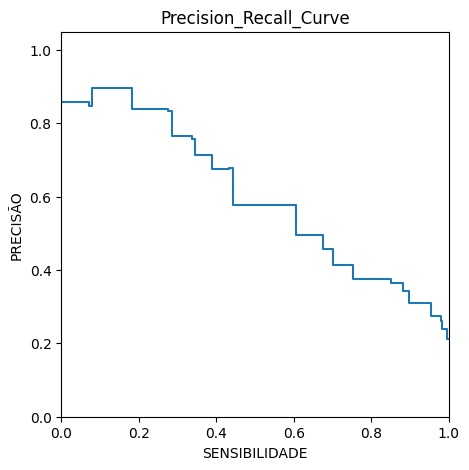

In [199]:
precision, recall, thresholds = precision_recall_curve(target_test, best_model_probabilities_test[:, 1])

plt.figure(figsize = (5,5))
plt.step(recall, precision, where = 'post')
plt.xlabel('SENSIBILIDADE')
plt.ylabel('PRECISÃO')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision_Recall_Curve')

plt.show()

### Curva ROC do melhor modelo

A Curva ROC é traçada com base na TFP (Taxa de Falsos Positivos) e TVP (Taxa de Verdadeiros Positivos).

Um modelo que responde aleatoriamente tem uma linha diagonal do canto inferior esquerdo ao superior direito. Quanto mais a curva ROC se diatancia dessa diagonal em direção ao canto superior esquerdo, melhor é o modelo, já que isso indica uma relação TVP-TFP mais elevada.

Vamos traçar nossa Curva ROC:

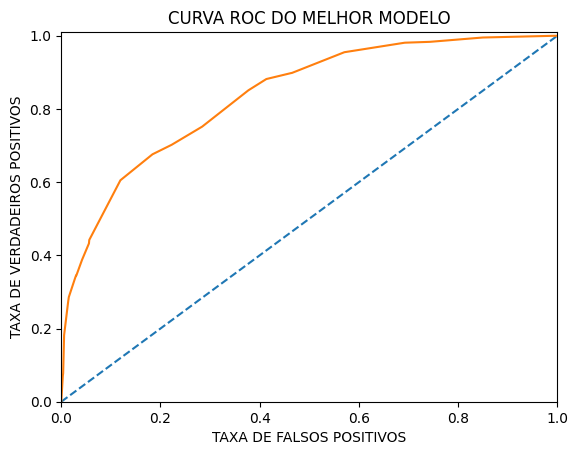

In [200]:
fpr, tpr, thresholds = roc_curve(target_test, best_model_probabilities_one_test)

plt.figure()

# Traçando a curva ROC para um modelo aleatório (50%)
plt.plot([0, 1], [0,1], linestyle = '--')

# Traçando a curva ROC para o melhor modelo com os dados de teste
plt.plot(fpr, tpr)
plt.xlabel('TAXA DE FALSOS POSITIVOS')
plt.ylabel('TAXA DE VERDADEIROS POSITIVOS')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('CURVA ROC DO MELHOR MODELO')

plt.show()

### Cálculo do AUC-ROC do melhor modelo

Para descobrir a diferença do nosso modelo para um modelo aleatório, vamos calcular o valor **AUC-ROC** (Area Under Curve-ROC) ou **Área Sob a Curva-ROC**. Isso é uma métrica de avaliação com valores no intervalo de 0 a 1. Lembrando que AUC-ROC para o modelo aleatório (diagonal) é igual a 0.5.

Vamos calcular nosso valor AUC-ROC:

In [201]:
auc_roc = roc_auc_score(target_test, best_model_probabilities_one_test)
print('Resultado de auc_roc para o melhor modelo:', auc_roc)

Resultado de auc_roc para o melhor modelo: 0.8362475658513111


Enquanto um AUC-ROC de um modelo aleatório é de 0.5, o nosso modelo apresentou um AUC-ROC de 0.84, o que é um resultado muito positivo, pois nos mostra que o nosso melhor modelo é muito superior a um modelo aleatório e de fato aprendeu padrões importantes dos dados analisados.

## Conclusões Finais

Nosso melhor modelo treinado foi um modelo de Árvore Decisória que alcançou um bom resultado com os dados de teste, sendo o F1 igual a 0.59 e o resultado de AUC-ROC de 0.84, o que foi bem superior a um AUC-ROC de um modelo aleatório de 0.5 e mostra que nosso modelo aprendeu padrões importantes no conjunto de dados. 

Nosso modelo final apresentou uma Sensibilidade de 0.70 e uma Precisão de 0.46, o que culminou no nosso resultado de F1_Score já citado acima. Porém, aqui é importante citar a sensibilidade, pois neste caso específico, ela é um parâmetro muito importante, pois como o banco está buscando encontrar padrões de clientes que tem tendência a deixar de utilizar os servços do banco, é melhor obtermos mais resultados de Falso Positivo do que de Falso Negativo. Ou seja, no caso de uma campanha para reter clientes, é melhor incluir um cliente FP na campanha do que deixar de atingir um cliente FN, então quanto menor o nosso número de FN, melhor.

Durante todo o processo, também foi possível observarmos a importância de realizarmos a preparação dos dados com a Codificação, além de analisarmos e tratarmos o desequilíbrio das Classes, utilizando as técnicas de Superamostragem e de Ajuste do limiar. Todas essas técnicas fizeram com que alcançássemos um resultado muito mais satisfatório, pois o nosso modelo de Árvore Decisória saltou de um F1_Score de 0.46, obtido antes do tratamento do desequilíbrio, para um F1_Score igual a 0.59 no nosso modelo final. 

<center>
    
# Renan Rosental de Oliveira